In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch 
from torch import nn
import pickle
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/churn-dataset/Churn_Modelling.csv


In [54]:
dataset = pd.read_csv("/kaggle/input/churn-dataset/Churn_Modelling.csv")
X = dataset.iloc[:,3:-1].values
y = dataset.iloc[:, -1].values

In [55]:
print(X)

[[619 'France' 'Female' ... 1 1 101348.88]
 [608 'Spain' 'Female' ... 0 1 112542.58]
 [502 'France' 'Female' ... 1 0 113931.57]
 ...
 [709 'France' 'Female' ... 0 1 42085.58]
 [772 'Germany' 'Male' ... 1 0 92888.52]
 [792 'France' 'Female' ... 1 0 38190.78]]


In [56]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
X[:, 2]=le.fit_transform(X[:,2])

In [57]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X)).astype(float)

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [59]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train=sc.fit_transform(X_train)
X_test=sc.transform(X_test)

In [60]:
X_train=torch.from_numpy(X_train).type(torch.float32)
y_train=torch.from_numpy(y_train).type(torch.float32)

In [61]:
class ann(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer1 = nn.Linear(in_features = 12, out_features = 32)
        self.layer2 = nn.Linear(in_features = 32, out_features = 48)
        self.layer3 = nn.Linear(in_features = 48, out_features = 64)
        self.layer4 = nn.Linear(in_features = 64, out_features = 1)
        self.loss_fn = nn.BCEWithLogitsLoss()
        self.optimizer = torch.optim.Adam(self.parameters(), lr = 0.002)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def forward(self, x):
        x = nn.functional.relu(self.layer1(x))
        x = nn.functional.relu(self.layer2(x))
        x = nn.functional.relu(self.layer3(x))
        return self.layer4(x)

    def accuracy_fn(self,y_true, y_pred):
        correct = torch.eq(y_true, y_pred).sum().item()
        acc = (correct / len(y_pred)) * 100 
        return acc
    
    def fit(self, X_train, y_train, epochs):
        torch.manual_seed(42)
        X_train, y_train = X_train.to(self.device), y_train.to(self.device)
        for epoch in range(epochs):
            
            self.train()
            y_logits = self.forward(X_train).squeeze()
            y_pred = torch.round(torch.sigmoid(y_logits))

            loss = self.loss_fn(y_logits,
                           y_train) 
            acc = self.accuracy_fn(y_true=y_train, 
                              y_pred=y_pred) 
            
            self.optimizer.zero_grad()

            loss.backward()
            
            self.optimizer.step()
            if epoch % 50 == 0:
                print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}%")

    def predict(self, X):
        X= X.to(self.device)
        self.eval()
        with torch.no_grad():
            logits = self.forward(X)
            probs = torch.sigmoid(logits)
            preds = (probs > 0.35).int()
        return preds


In [62]:
model= ann()

In [63]:
model.to(model.device)
model.fit(X_train, y_train, epochs=550)
torch.save(model.state_dict(), "model.pkl")

Epoch: 0 | Loss: 0.68356, Accuracy: 76.21%
Epoch: 50 | Loss: 0.43628, Accuracy: 79.51%
Epoch: 100 | Loss: 0.36120, Accuracy: 85.11%
Epoch: 150 | Loss: 0.31543, Accuracy: 86.83%
Epoch: 200 | Loss: 0.29684, Accuracy: 87.69%
Epoch: 250 | Loss: 0.28013, Accuracy: 88.21%
Epoch: 300 | Loss: 0.26626, Accuracy: 88.96%
Epoch: 350 | Loss: 0.25645, Accuracy: 89.24%
Epoch: 400 | Loss: 0.24483, Accuracy: 89.65%
Epoch: 450 | Loss: 0.23753, Accuracy: 90.12%
Epoch: 500 | Loss: 0.23013, Accuracy: 90.56%


In [64]:
model_instance = ann()
model_instance.load_state_dict(torch.load("model.pkl"))
model_instance.to(model_instance.device)

<ipython-input-64-c31036fd4a3b>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_instance.load_state_dict(torch.load("model.pkl"))


ann(
  (layer1): Linear(in_features=12, out_features=32, bias=True)
  (layer2): Linear(in_features=32, out_features=48, bias=True)
  (layer3): Linear(in_features=48, out_features=64, bias=True)
  (layer4): Linear(in_features=64, out_features=1, bias=True)
  (loss_fn): BCEWithLogitsLoss()
)

In [65]:
test_case=[[1, 0, 0, 600, 1, 40, 3, 60000, 2, 1, 1, 50000]]
test_case=sc.transform(test_case)
test_case=torch.from_numpy(test_case).type(torch.float32)
prediction=model_instance.predict(test_case)

print("No churn") if prediction==0 else print("chrun")

No churn


In [66]:
X_test=torch.from_numpy(X_test).type(torch.float32)
y_test=torch.from_numpy(y_test).type(torch.float32)
predictions=model_instance.predict(X_test)

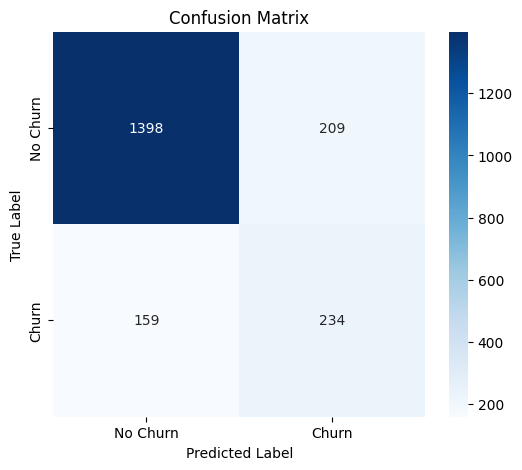

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

predictions=predictions.cpu()

# Compute confusion matrix
cm = confusion_matrix(y_test, predictions)
# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn', 'Churn'], yticklabels=['No Churn', 'Churn'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()